In [287]:
import pandas as pd
import numpy as np
import datetime
import tqdm #進度條
import talib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline
data = pd.read_csv('data/1019_SP.csv')
Date = data.get("Date")
Date = pd.to_datetime(Date)
Open = data.get("Open")
High = data.get("High")
Low = data.get("Low")
Close = data.get("Close")

dict = {"Date": Date,
        "open": Open,
        "high": High,
        "low": Low, 
        "close": Close
       }
df = pd.DataFrame(dict)
df.set_index('Date', inplace=True)
df = df.dropna()
print("總共:%d個交易時間點" % (len(Date)))
print("去除空白值後剩下:%d個交易時間點" % (len(df)))
df.tail(10)

總共:2493個交易時間點
去除空白值後剩下:2493個交易時間點


,open,high,low,close
Date,,,,
2019-12-13,3166.649902,3182.679932,3156.510010,3168.800049
2019-12-16,3183.629883,3197.709961,3183.629883,3191.449951
2019-12-17,3195.399902,3198.219971,3191.030029,3192.520020
2019-12-18,3195.209961,3198.479980,3191.139893,3191.139893
2019-12-19,3192.320068,3205.479980,3192.320068,3205.370117
2019-12-20,3223.330078,3225.649902,3216.030029,3221.219971
2019-12-23,3226.050049,3227.780029,3222.300049,3224.010010
2019-12-26,3227.199951,3240.080078,3227.199951,3239.909912
2019-12-27,3247.229980,3247.929932,3234.370117,3240.020020


In [ ]:
ema = talib.EMA(df['close'])
sma = talib.SMA(df['close'])
roc = talib.ROC(df['close'])
macd, macdsignal, macdhist = talib.MACD(df['close'])
k, d = talib.STOCH (df['high'], df['low'], df['close'])
upper, middle, lower = talib.BBANDS(df['close'])
B = (df['close'] - lower)/(upper - lower)

dataset = pd.DataFrame({
    'Close':df['close'],    
    'EMA':ema,
    'SMA':sma,
    'ROC':roc,
    'MACD':macd,
    '%K':k,
    '%D':d,
    'Upper Band':upper,
    'Lower Band':lower,
    '%B':B,
    'return': df['close']
})

feature_names = list(dataset.columns[:-1])

In [289]:
print("before dropping NaN", dataset.shape)
dataset = dataset.dropna()
print("after dropping NaN", dataset.shape)

before dropping NaN (2493, 11)
after dropping NaN (2460, 11)


In [290]:
from sklearn.preprocessing import MinMaxScaler

ss = MinMaxScaler()

dataset_scaled = ss.fit_transform(dataset)
dataset_scaled = pd.DataFrame(dataset_scaled, columns=dataset.columns, index=dataset.index)
#dataset_scaled['return'] = dataset['return']
dataset_scaled.describe()

,Close,EMA,SMA,ROC,MACD,%K,%D,Upper Band,Lower Band,%B,return
count,2460.000000,2460.000000,2460.000000,2460.000000,2460.000000,2460.000000,2460.000000,2460.000000,2460.000000,2460.000000,2460.000000
mean,0.428129,0.424185,0.425646,0.656687,0.641694,0.606793,0.615276,0.431052,0.426996,0.557574,0.428129
std,0.263129,0.278491,0.278821,0.100666,0.134407,0.264417,0.251097,0.265637,0.261981,0.287313,0.263129
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.170140,0.147477,0.151014,0.608373,0.573992,0.395688,0.418844,0.168011,0.171626,0.297806,0.170140
50%,0.437414,0.435432,0.433881,0.664884,0.665200,0.647005,0.653687,0.439382,0.437114,0.629983,0.437414
75%,0.638417,0.647352,0.652223,0.719253,0.726499,0.844265,0.834867,0.638581,0.641608,0.802273,0.638417
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [291]:
from keras.utils import np_utils
#每張圖包含幾天的資料
time_period = 20
#預設幾日後的漲跌
day = 10

cnn_x = []
cnn_y = []
indexs = []
dataset_scaled_x= dataset_scaled[feature_names]

for i in tqdm.tqdm_notebook(range(0, len(dataset_scaled)-time_period-1-day)):
    cnn_x.append(dataset_scaled_x.iloc[i:i+time_period].values)
    r = dataset_scaled['return'].iloc[i+time_period-1+day]/dataset_scaled['return'].iloc[i+time_period-1]
    if r > 1:
        r = 0
    else:
        r = 1
    rr = np_utils.to_categorical(r, num_classes=2)
    cnn_y.append(rr)
    indexs.append(dataset_scaled.index[i+time_period-1])
    
cnn_x = np.array(cnn_x)
cnn_y = np.array(cnn_y)
indexes = np.array(indexs)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  


In [ ]:
#2010~2018年為訓練和測試，2019年則為驗證
import datetime
cnn_x_t = cnn_x[indexes < datetime.datetime(2019,1,1)]
cnn_y_t = cnn_y[indexes < datetime.datetime(2019,1,1)]

In [ ]:
cnn_x_validation = cnn_x[indexes > datetime.datetime(2019,1,1)]
cnn_y_validation = cnn_y[indexes > datetime.datetime(2019,1,1)]

In [ ]:
from sklearn.model_selection import train_test_split
cnn_x_train, cnn_x_test, cnn_y_train, cnn_y_test = train_test_split(cnn_x_t, cnn_y_t, test_size=0.2,random_state =7,stratify=cnn_y_t,shuffle = True)

In [ ]:
cnn_x_train = np.stack((cnn_x_train,)*3,axis=-1)
cnn_x_test = np.stack((cnn_x_test,)*3,axis=-1)
cnn_x_validation = np.stack((cnn_x_validation,)*3,axis=-1)

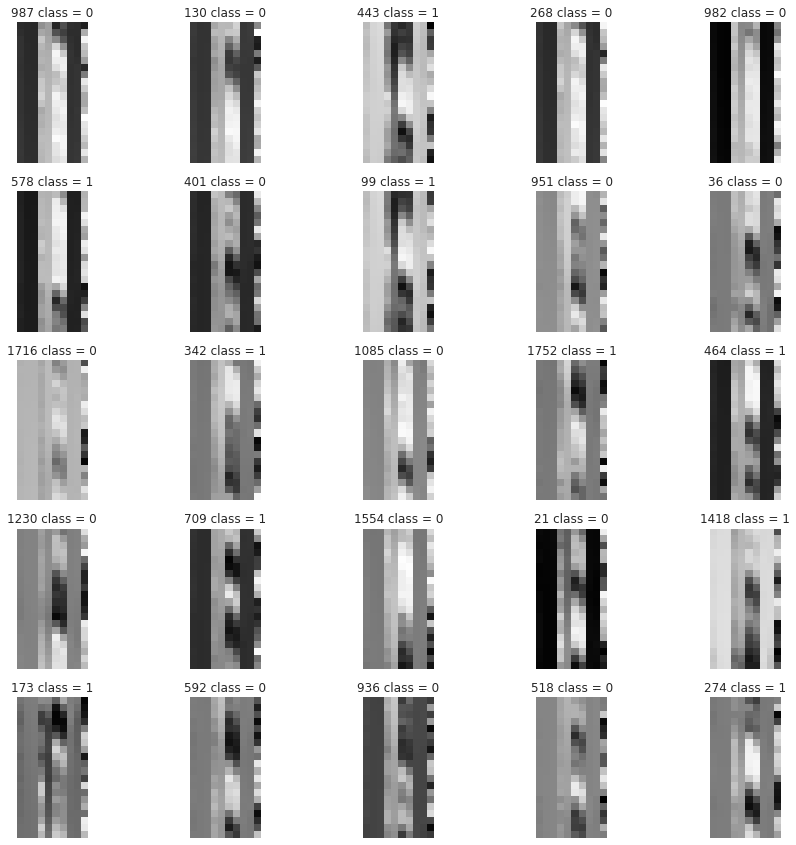

In [296]:
fig = plt.figure(figsize = (15,15))
columns = rows = 5
for i in range(1,columns*rows+1):
  index = np.random.randint(len(cnn_x_train))
  img = cnn_x_train[index]
  fig.add_subplot(rows,columns,i)
  plt.axis("off")
  plt.title(str(index)+' class = '+str(np.argmax(cnn_y_train[index])))
  plt.subplots_adjust(wspace=0.2,hspace=0.2)
  plt.imshow(img)
plt.show()

In [297]:
import tensorflow.keras
import tensorflow.keras.layers as layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.initializers import he_normal

input_shape = cnn_x_train[0].shape

model = Sequential()
model.add(layers.Conv2D(filters=32, 
                        kernel_size=(3,3), 
                        activation='relu',
                        padding="same",
                        input_shape=input_shape))
model.add(layers.Conv2D(filters=64, 
                        kernel_size=(3,3), 
                        activation='relu',
                        padding="same"))
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Dropout(0.25))
model.add(layers.Flatten())
model.add(layers.Dense(units=128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(units=2, activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer="Adam", metrics=['accuracy'])

print(model.summary())

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 20, 10, 32)        896       
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 20, 10, 64)        18496     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 10, 5, 64)         0         
_________________________________________________________________
dropout_36 (Dropout)         (None, 10, 5, 64)         0         
_________________________________________________________________
flatten_18 (Flatten)         (None, 3200)              0         
_________________________________________________________________
dense_36 (Dense)             (None, 128)               409728    
_________________________________________________________________
dropout_37 (Dropout)         (None, 128)             

In [298]:
from tensorflow.keras.callbacks import EarlyStopping 
earlystop = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

history = model.fit(cnn_x_train, cnn_y_train,
                    batch_size=100,
                    epochs=250,
                    verbose=1,
                    validation_data=(cnn_x_test,cnn_y_test),
                    callbacks=[earlystop],
                    )

Epoch 1/250
18/18 [==============================] - 0s 10ms/step - loss: 0.6785 - accuracy: 0.6174 - val_loss: 0.6632 - val_accuracy: 0.6264
Epoch 2/250
18/18 [==============================] - 0s 6ms/step - loss: 0.6652 - accuracy: 0.6254 - val_loss: 0.6571 - val_accuracy: 0.6264
Epoch 3/250
18/18 [==============================] - 0s 5ms/step - loss: 0.6609 - accuracy: 0.6254 - val_loss: 0.6575 - val_accuracy: 0.6264
Epoch 4/250
18/18 [==============================] - 0s 5ms/step - loss: 0.6630 - accuracy: 0.6254 - val_loss: 0.6619 - val_accuracy: 0.6264
Epoch 5/250
18/18 [==============================] - 0s 5ms/step - loss: 0.6622 - accuracy: 0.6254 - val_loss: 0.6588 - val_accuracy: 0.6264
Epoch 6/250
18/18 [==============================] - 0s 5ms/step - loss: 0.6592 - accuracy: 0.6254 - val_loss: 0.6575 - val_accuracy: 0.6264
Epoch 7/250
18/18 [==============================] - 0s 6ms/step - loss: 0.6587 - accuracy: 0.6254 - val_loss: 0.6581 - val_accuracy: 0.6264
Epoch 8/250


In [299]:
o_loss,o_accuracy = model.evaluate(cnn_x_train,cnn_y_train)
print("對訓練資料的：\nLoss: %.2f, Accuracy: %.2f" % (o_loss, o_accuracy))
n_loss,n_accuracy = model.evaluate(cnn_x_test,cnn_y_test)
print("對測試資料的：\nLoss: %.2f, Accuracy: %.2f" % (n_loss, n_accuracy))

55/55 [==============================] - 0s 2ms/step - loss: 0.1327 - accuracy: 0.9704
對訓練資料的：
Loss: 0.13, Accuracy: 0.97
14/14 [==============================] - 0s 2ms/step - loss: 0.5236 - accuracy: 0.7540
對測試資料的：
Loss: 0.52, Accuracy: 0.75


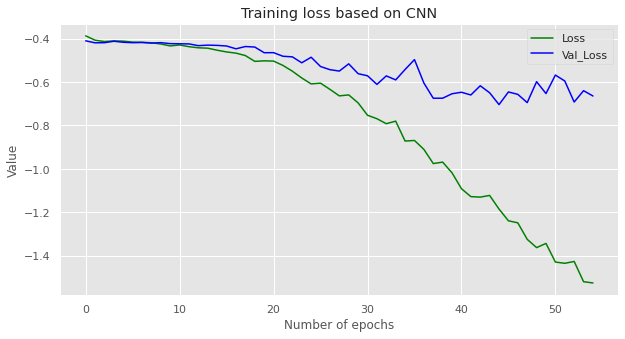

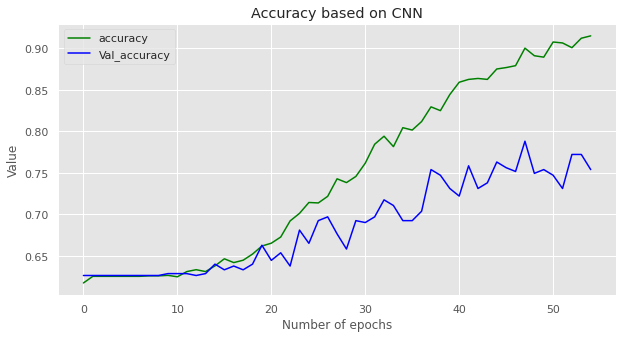

In [300]:
plt.style.use("ggplot")
plt.figure(figsize=(10, 5))
plt.plot(np.log(history.history['loss']), color = 'green', label='Loss')
plt.plot(np.log(history.history['val_loss']), color = 'blue', label='Val_Loss')
plt.legend()
plt.title('Training loss based on CNN')
plt.ylabel('Value')
plt.xlabel('Number of epochs')
plt.show()
plt.style.use("ggplot")
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], color = 'green', label='accuracy')
plt.plot(history.history['val_accuracy'], color = 'blue', label='Val_accuracy')
plt.legend()
plt.title('Accuracy based on CNN')
plt.ylabel('Value')
plt.xlabel('Number of epochs')
plt.show()

In [ ]:
pre = model.predict_classes(cnn_x_test)
pre = pd.Series(pre)

TP: 242.00, FN: 33.00, FP: 75.00, TN: 89.00
對訓練集資料的：Loss: 0.13, Accuracy: 0.97
對測試集資料的：Loss: 0.52, Accuracy: 0.75

測試資料總共：439.00 筆, 其中漲的筆數為: 275.00, 全部猜漲猜對的機率是: 0.63
該測試集資料的：
Accuracy: 0.75, Precision: 0.76, Recall: 0.88
F1 score: 0.82


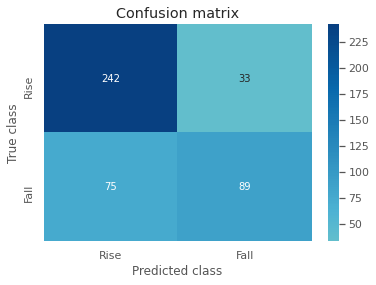

In [302]:
from sklearn.metrics import confusion_matrix

#將onehot編碼轉回數組cnn_x_validation
cnn_y_test = np.argmax(cnn_y_test, axis=1)
xcnn_y_test = pd.Series(cnn_y_test)

LABELS = ["Rise","Fall"]
conf_matrix = confusion_matrix(xcnn_y_test, pre)

t_size = len(cnn_y_test)
t_size1 = (cnn_y_test<1).sum()
t_guess = ((cnn_y_test<1).sum())/(len(cnn_y_test))

TP = conf_matrix[0][0]
FN = conf_matrix[0][1]
FP = conf_matrix[1][0]
TN = conf_matrix[1][1]
accuracy = (TP+TN)/(TP+FN+FP+TN)
precision = TP/(TP+FP)
recall = TP/(TP+FN)
F1 = 2*((precision*recall)/(precision+recall))
print("TP: %.2f, FN: %.2f, FP: %.2f, TN: %.2f" % (TP,FN,FP,TN))
print("對訓練集資料的：Loss: %.2f, Accuracy: %.2f" % (o_loss, o_accuracy))
print("對測試集資料的：Loss: %.2f, Accuracy: %.2f" % (n_loss, n_accuracy))
print("\n測試資料總共：%.2f 筆, 其中漲的筆數為: %.2f, 全部猜漲猜對的機率是: %.2f" % (t_size, t_size1, t_guess))
print("該測試集資料的：\nAccuracy: %.2f, Precision: %.2f, Recall: %.2f\nF1 score: %.2f" % (accuracy, precision,recall,F1))

sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d",center=0.7,cmap = 'GnBu');
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

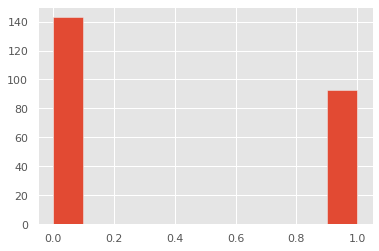

In [303]:
pre = model.predict_classes(cnn_x_validation)
pre = pd.Series(pre)
pre.hist()

TP: 110.00, FN: 62.00, FP: 33.00, TN: 31.00
對訓練集資料的：Loss: 0.13, Accuracy: 0.97
對測試集資料的：Loss: 0.52, Accuracy: 0.75

測試資料總共：236.00 筆, 其中漲的筆數為: 172.00, 全部猜漲猜對的機率是: 0.73
該測試集資料的：
Accuracy: 0.60, Precision: 0.77, Recall: 0.64
F1 score: 0.70


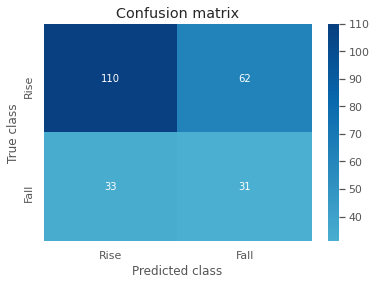

In [304]:
from sklearn.metrics import confusion_matrix

#將onehot編碼轉回數組cnn_x_validation
cnn_y_validation = np.argmax(cnn_y_validation, axis=1)
xcnn_y_validation = pd.Series(cnn_y_validation)

LABELS = ["Rise","Fall"]
conf_matrix = confusion_matrix(xcnn_y_validation, pre)

t_size = len(cnn_y_validation)
t_size1 = (cnn_y_validation<1).sum()
t_guess = ((cnn_y_validation<1).sum())/(len(cnn_y_validation))

TP = conf_matrix[0][0]
FN = conf_matrix[0][1]
FP = conf_matrix[1][0]
TN = conf_matrix[1][1]
accuracy = (TP+TN)/(TP+FN+FP+TN)
precision = TP/(TP+FP)
recall = TP/(TP+FN)
F1 = 2*((precision*recall)/(precision+recall))
print("TP: %.2f, FN: %.2f, FP: %.2f, TN: %.2f" % (TP,FN,FP,TN))
print("對訓練集資料的：Loss: %.2f, Accuracy: %.2f" % (o_loss, o_accuracy))
print("對測試集資料的：Loss: %.2f, Accuracy: %.2f" % (n_loss, n_accuracy))
print("\n測試資料總共：%.2f 筆, 其中漲的筆數為: %.2f, 全部猜漲猜對的機率是: %.2f" % (t_size, t_size1, t_guess))
print("該測試集資料的：\nAccuracy: %.2f, Precision: %.2f, Recall: %.2f\nF1 score: %.2f" % (accuracy, precision,recall,F1))

sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d",center=0.7,cmap = 'GnBu');
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()